In [4]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from uncertainties import ufloat, unumpy
from scipy.odr import ODR, Model, RealData
from scipy.optimize import fsolve
from matplotlib.ticker import AutoMinorLocator
from scipy import constants

### Data Loader

In [5]:
def load_data(path):
    np.set_printoptions(suppress=True, precision=10)
    data_list = sorted(glob.glob(path))
    data_np = []
    for i in data_list:
        data = pd.read_csv(i, sep=',')
        data_np.append(data.to_numpy())
    return data_np

In [6]:
path_planck = '/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C45/Planck/*.csv'
data366, data405, data436, data546, data578 = load_data(path=path_planck)

# Measuring the Planck constant

## Custom functions

In [7]:
def exp(p, x):
    A, B, C, U = p
    return A+B*(np.exp(C*(x-U)-1))

def lin(p, x):
    A, M, U = p
    return A+M*(x-U)

def calc_sx(data, range):
    return 0.00025*abs(data)+0.00005*range

def err_x0(beta_exp, beta_lin, cov_lin): #error is calculated using the absoult maximum of the difference of the actual intersection point between exp and lin+/- error of the
    x0s = []
    for i in [beta_lin, beta_lin + cov_lin[1], beta_lin - cov_lin[1]]:
        def diff(x):
            return exp(beta_exp, x) - lin(i, x)
        x0s.append(fsolve(diff, -1.3))
    dx0 = np.max([abs(x0s[0]-x0s[1]), abs(x0s[0]-x0s[2])])
    return dx0



def piecewise(data, threshold, intersection, betaLin, betaExp, mark=False, print_beta=False): #x, y, sx, sy
    modelExp = Model(exp)
    modelLin = Model(lin)
    dataLin = RealData(data[0][:threshold], data[1][:threshold], sx=data[2][:threshold], sy=data[3][:threshold])
    dataExp = RealData(data[0][threshold:], data[1][threshold:], sx=data[2][threshold:], sy=data[3][threshold:])
    odrExp = ODR(dataExp, modelExp, beta0=betaExp)
    odrLin = ODR(dataLin, modelLin, beta0=betaLin)
    outputExp = odrExp.run()
    outputLin = odrLin.run()
    def diff(x):
        return exp(outputExp.beta, x) - lin(outputLin.beta, x)
    x0 = fsolve(diff, intersection)
    sx0 = err_x0(outputExp.beta, outputLin.beta, outputLin.sd_beta)
    if print_beta:
        print('Linear:')
        outputLin.pprint()
        print()
        print('Exponential:')
        outputExp.pprint()
    if mark:
        x_plot = np.linspace(np.min(data[0]), np.max(data[0]), 1000)
        plt.scatter(x0, exp(outputExp.beta, x0), c='lime', zorder=3)
        plt.scatter(data[0][:threshold], data[1][:threshold], c='red', s=8)
        plt.scatter(data[0][threshold:], data[1][threshold:], c='blue', s=8)
        plt.plot(x_plot, exp(outputExp.beta, x_plot), c='blue', linewidth=.8)
        plt.plot(x_plot, lin(outputLin.beta, x_plot), c='red', linewidth=.8)
    
    return outputLin.beta, outputExp.beta, x0, sx0

def plot_planck(data_fit, realData, wavelength, name, save=False, hide=False):
    fig, ax = plt.subplots(dpi=150)

    plt.rcParams["font.family"] = "times"
    plt.rcParams["text.usetex"] = True

    x_lin = np.linspace(min(realData[0]), data_fit[2], 1000)
    x_exp = np.linspace(data_fit[2], max(realData[0])+.1, 1000)

    ax.errorbar(realData[0], realData[1],
                xerr=realData[2], yerr=realData[3],
                capsize=4,
                ecolor='black',
                elinewidth=.6,
                capthick=.6,
                markersize=4, fmt="s",
                markeredgecolor='none', c="black",
                label=f'Photocurrent at $\lambda$={wavelength}nm',
                zorder=2)
    ax.plot(x_lin, lin(data_fit[0], x_lin),
            c='red',
            linewidth=.8,
            label='Piecewise fit',
            zorder=3)
    ax.plot(x_exp, exp(data_fit[1], x_exp),
            c='red',
            linewidth=.8,
            zorder=3)
    for i in [data_fit[2]+data_fit[3], data_fit[2]-data_fit[3]]:
        ax.axvline(i,
                color='grey',
                linestyle='--',
                linewidth=0.8,
                zorder=3)
    ax.axvline(data_fit[2],
                color='grey',
                linestyle='-',
                linewidth=0.8,
                zorder=3)
    ax.set_ylabel('Anode current [nA]', fontsize=12)
    ax.set_xlabel('Counter voltage [V]', fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
    ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

    plt.annotate(f'{data_fit[2][0]:.3f}', xy=(data_fit[2], ax.get_ylim()[1]), ha='center', va='bottom')

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 0]  

    plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           loc="upper left",
           bbox_to_anchor=(0.02, 0.98),
           fancybox=False,
           edgecolor='black',
           fontsize=10)
    if hide:
        plt.close()
    if save:
        fig.savefig(f'/Users/danielmiksch/Downloads/{name}.pdf')

## Fits

In [8]:
data_fits = []
for i in [data366, data405, data436, data546, data578]:
    x, y, sy, sx = i[:,0], i[:,1], i[:,2], calc_sx(i[:,0], 10)
    data_fits.append([x, y, sx, sy])

In [83]:
fit366 =  piecewise(data_fits[0], 8, -1.3, betaLin=[1,1,1], betaExp=[1,1,1,-1], mark=False, print_beta=False) #data366
fit405 = piecewise(data_fits[1], 10, -1.3, betaLin=[1,1,1], betaExp=[0,.5,1,-1.39], mark=False, print_beta=False) #data405
fit436 = piecewise(data_fits[2], 10, -1.3, betaLin=[1,1,1], betaExp=[0,.5,1,-1.39], mark=False, print_beta=False) #data436
fit546 = piecewise(data_fits[3], 10, -1.3, betaLin=[1,1,1], betaExp=[0,.5,1,-1.39], mark=False, print_beta=False) #data546
fit578 = piecewise(data_fits[4], 13, -.5, betaLin=[1,1,1], betaExp=[0,1,0,0], mark=False, print_beta=False) #data578

breakingVoltage_display = np.array([f'{i[2][0]}+/-{i[3]} V' for i in [fit366, fit405, fit436, fit546, fit578]])

/var/folders/_s/ymfv76ms5rs0hd9l43mh92_80000gn/T/ipykernel_47219/1095918607.py:3: RuntimeWarning: overflow encountered in exp
  return A+B*(np.exp(C*(x-U)-1))


## Plots

In [84]:
plot_planck(fit366, data_fits[0], 366, 'fit366', save=False, hide=True,)
plot_planck(fit405, data_fits[1], 405, 'fit405', save=False, hide=True,)
plot_planck(fit436, data_fits[2], 436, 'fit436', save=False, hide=True,)
plot_planck(fit546, data_fits[3], 546, 'fit546', save=False, hide=True,)
plot_planck(fit578, data_fits[4], 578, 'fit578', save=False, hide=True,)

In [85]:
breakingVoltage = np.array([abs(i[2][0]) for i in [fit366, fit405, fit436, fit546, fit578]])
sBV = np.array([i[3] for i in [fit366, fit405, fit436, fit546, fit578]])
freq = constants.c / (np.array([366, 405, 436, 546, 578])*1e-9)
sFreq = constants.c / (np.array([366, 405, 436, 546, 578])*1e-9) * 0.01

### Plot breaking voltages

In [94]:
def linear(p, x):
    A, B = p
    return A+B*x

model_lin = Model(linear)
data_lin = RealData(x=freq, y=breakingVoltage, sx=sFreq, sy=sBV)
odrLin = ODR(data_lin, model_lin, beta0=[-1, 1e-10])
lin_output = odrLin.run()
lin_output.pprint

3.905158069137291e-15

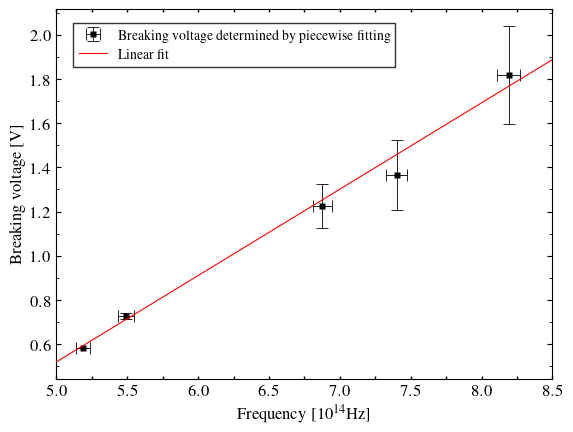

In [106]:
fig, ax = plt.subplots(dpi=100)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

x = np.linspace(5, 8.5, 1000)


ax.errorbar(freq / 1e14, breakingVoltage,
            capsize=4,
            xerr=sFreq / 1e14, yerr=sBV,
            ecolor='black',
            elinewidth=.6,
            capthick=.6,
            markersize=4, fmt="s",
            markeredgecolor='none', c="black",
            label=f'Breaking voltage determined by piecewise fitting',
            zorder=2)
ax.set_xlim(5, 8.5)
ax.plot(x, linear([lin_output.beta[0], lin_output.beta[1] * 1e14], x),
        c='red',
        linewidth=.8,
        label='Linear fit',
        zorder=3)
ax.set_ylabel('Breaking voltage [V]', fontsize=12)
ax.set_xlabel(r'Frequency [$10^{14}$Hz]', fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  

plt.legend([handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.02, 0.98),
        fancybox=False,
        edgecolor='black',
        fontsize=10)
plt.show()

# fig.savefig('/Users/danielmiksch/Downloads/breaking_voltages.pdf')

## Final result of the Planck constant

In [109]:
planck = ufloat(lin_output.beta[1], np.sqrt(lin_output.cov_beta[1][1])) * constants.e
planck * 1e34

6.256753010448323+/-0.6213589014422587

In [116]:
relatice_err = planck.std_dev / planck.nominal_value
f'{relatice_err * 100}%'

'9.931012146470135%'